In [1]:
%matplotlib inline
import os

import numpy as np
import xarray as xr

import utils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs
import cmocean

Author: Mike Levy

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1127.18.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

Hostname: crhtc61

Git hash: 3c1238f9ed63400aedac42ee7963b91d790b2b45

cmocean   : 2.0
numpy     : 1.20.2
sys       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
xarray    : 0.17.0
cartopy   : 0.18.0
matplotlib: 3.4.1
json      : 2.0.9



In [2]:
nutrients = ['NO3', 'PO4', 'SiO3']

In [3]:
ds_surf_plot = xr.open_zarr('data/nutrients-surface-maps.zarr')
ds_surf_plot

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    NO3       (nlat, nlon) float32 dask.array<chunksize=(192, 321), meta=np.ndarray>
    NO3_obs   (nlat, nlon) float32 dask.array<chunksize=(192, 321), meta=np.ndarray>
    PO4       (nlat, nlon) float32 dask.array<chunksize=(192, 321), meta=np.ndarray>
    PO4_obs   (nlat, nlon) float32 dask.array<chunksize=(192, 321), meta=np.ndarray>
    SiO3      (nlat, nlon) float32 dask.array<chunksize=(192, 321), meta=np.ndarray>
    SiO3_obs  (nlat, nlon) float32 dask.array<chunksize=(192, 321), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(192, 161), meta=np.ndarray>
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(192, 161), meta=np.ndarray>

In [4]:
ds_zonal_mean = xr.open_zarr('data/nutrients-zonal-section.zarr').compute()
for v in nutrients:
    ds_zonal_mean[f'{v}_bias'] = ds_zonal_mean[v] - ds_zonal_mean[f'{v}_obs']
        
ds_zonal_mean = ds_zonal_mean.drop('basins').rename({'region': 'basins'})
ds_zonal_mean 

<xarray.Dataset>
Dimensions:    (basins: 4, lat_t: 394, z_t: 60)
Coordinates:
  * lat_t      (lat_t) float32 -79.22 -78.69 -78.15 -77.62 ... 88.84 89.37 89.9
  * basins     (basins) <U14 'Global' 'Atlantic Ocean' ... 'Indian Ocean'
  * z_t        (z_t) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
    z_t_       (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    NO3        (basins, z_t, lat_t) float32 nan nan 19.02 19.07 ... nan nan nan
    NO3_obs    (basins, z_t, lat_t) float32 nan nan 20.99 21.69 ... nan nan nan
    PO4        (basins, z_t, lat_t) float32 nan nan 1.423 1.428 ... nan nan nan
    PO4_obs    (basins, z_t, lat_t) float32 nan nan 1.713 1.705 ... nan nan nan
    SiO3       (basins, z_t, lat_t) float32 nan nan 42.66 43.43 ... nan nan nan
    SiO3_obs   (basins, z_t, lat_t) float32 nan nan 61.78 62.55 ... nan nan nan
    NO3_bias   (basins, z_t, lat_t) float32 nan nan -1.967 ... nan nan nan
    PO4_bias   (basins, z_t, lat_t) float32 nan nan -0.2902 ... nan nan nan
    SiO3_bias  (basins, z_t, lat_t) float32 nan nan -19.12 ... nan nan nan

In [5]:
glb_avg = xr.open_zarr('data/nutrients-global-profile.zarr')
glb_avg

<xarray.Dataset>
Dimensions:   (z_t: 60)
Coordinates:
  * z_t       (z_t) float64 5.0 15.0 25.0 35.0 ... 4.875e+03 5.125e+03 5.375e+03
Data variables:
    NO3       (z_t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    NO3_obs   (z_t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    PO4       (z_t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    PO4_obs   (z_t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    SiO3      (z_t) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    SiO3_obs  (z_t) float64 dask.array<chunksize=(60,), meta=np.ndarray>

In [6]:
class contour_label_format(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

def contour_label(cl):
    cl.levels = [contour_label_format(val) for val in cl.levels]
    fmt = '%r'
    return plt.clabel(cl, fontsize=5, inline=True, fmt=fmt)

In [7]:
cmap_field = cmocean.cm.dense
cmap_bias = cmocean.cm.balance

levels = dict(
    NO3=[0, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 8, 12., 16, 20, 24, 28, 32,],
    PO4=[0, 0.02, 0.04, 0.08, 0.12, 0.16, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.2, 1.4, 1.6, 1.8, 2.0],
    SiO3=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,]
)

def mirror_levels(v, lmax):
    half = np.array(levels[v])[np.where(np.array(levels[v]) <= lmax)[0]]
    return np.concatenate((-half[:0:-1], half))
    
levels_bias = dict(
    NO3=np.arange(-12, 14, 2), #mirror_levels('NO3', 12),
    PO4=np.arange(-1., 1.15, 0.15), #mirror_levels('PO4', 1),
    SiO3=np.arange(-50, 55, 5), #mirror_levels('SiO3', 50),
)    

contour_spec = dict(
    NO3=dict(
        levels=levels['NO3'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['NO3'], ncolors=cmap_field.N),
    ),
    NO3_bias=dict(
        levels=levels_bias['NO3'], 
        extend='both',        
        cmap=cmap_bias,
        norm=colors.BoundaryNorm(levels_bias['NO3'], ncolors=cmap_bias.N),        
    ),
    PO4=dict(
        levels=levels['PO4'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['PO4'], ncolors=cmap_field.N),        
    ),
    PO4_bias=dict(
        levels=levels_bias['PO4'], #
        extend='both',
        cmap=cmap_bias,   
        norm=colors.BoundaryNorm(levels_bias['PO4'], ncolors=cmap_bias.N),                
    ),
    SiO3=dict(
        levels=levels['SiO3'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['SiO3'], ncolors=256),        
    ),
    SiO3_bias=dict(
        levels=levels_bias['SiO3'], #
        extend='both',
        cmap=cmap_bias,   
        norm=colors.BoundaryNorm(levels_bias['SiO3'], ncolors=cmap_bias.N),                
    ),    
    
)

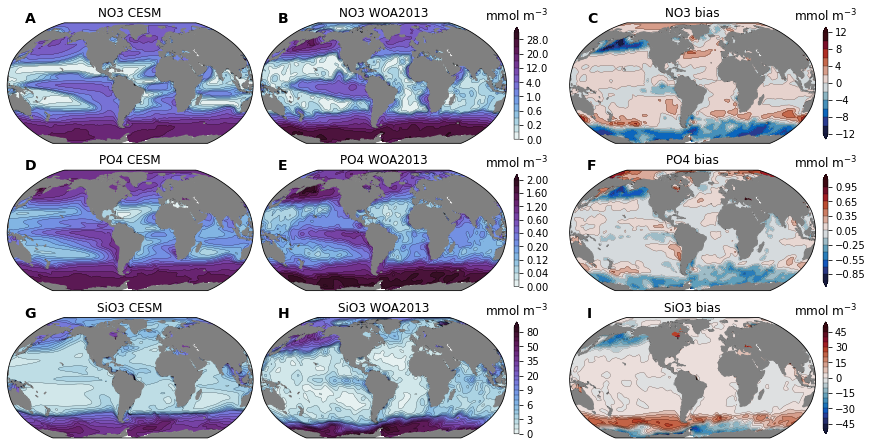

In [8]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 0.02, 1, 0.02))

prj = ccrs.Robinson(central_longitude=305.0)

axs = []
maps = []
for i, nut in enumerate(['NO3', 'PO4', 'SiO3']):
    ax_m = plt.subplot(gs[i, 0], projection=prj)
    ax_o = plt.subplot(gs[i, 1], projection=prj)
    ax_b = plt.subplot(gs[i, 3], projection=prj)
    
    cax_field = plt.subplot(gs[i, 2])
    cax_bias = plt.subplot(gs[i, 4])
    
    axs.append((ax_m, ax_o, cax_field, ax_b, cax_bias))
    maps.extend([ax_m, ax_o, ax_b])
    
    cesm = ds_surf_plot[nut]
    obs = ds_surf_plot[f'{nut}_obs']
    bias = cesm - obs

    units = ds_surf_plot[nut].units
    
    
    cf_m = ax_m.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
        **contour_spec[nut],        
        transform=ccrs.PlateCarree(),
    )
    
    cl_m = ax_m.contour(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
        levels=contour_spec[nut]['levels'], colors='k', linewidths=0.2,
        transform=ccrs.PlateCarree(),        
    )
    #contour_label(cl_m)   
    
    cf_o = ax_o.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
        **contour_spec[nut],        
        transform=ccrs.PlateCarree(),        
    )
    
    cl_o = ax_o.contour(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
        levels=contour_spec[nut]['levels'], colors='k', linewidths=0.2,
        transform=ccrs.PlateCarree(),        
    )
    #contour_label(cl_o)       
    
    cf_b = ax_b.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
        **contour_spec[f'{nut}_bias'],                     
        transform=ccrs.PlateCarree(),        
    )    

    cl_b = ax_b.contour(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
        levels=contour_spec[f'{nut}_bias']['levels'], colors='k', linewidths=0.2,
        transform=ccrs.PlateCarree(),        
    )
    #contour_label(cl_b)       
    
    for ax in [ax_m, ax_o, ax_b]:
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )        
        
    ax_m.set_title(f'{nut} CESM')
    ax_o.set_title(f'{nut} WOA2013')    
    ax_b.set_title(f'{nut} bias')        
    
    cb_field = plt.colorbar(cf_o, cax=cax_field, drawedges=True)
    cb_field.ax.set_title(units)
    cb_field.outline.set_linewidth(0.5)
    cb_field.dividers.set_linewidth(0.25)    
    
    cb_bias = plt.colorbar(cf_b, cax=cax_bias, drawedges=True)
    cb_bias.ax.set_title(units)
    cb_bias.outline.set_linewidth(0.5)
    cb_bias.dividers.set_linewidth(0.25)    
    
# add a gap between left two columns and right; scale colorbars
gs.update(left=0.05, right=0.95, hspace=0.05, wspace=0.05)
offset = 0.05
cax_vert_shrink = 0.8
for i in range(len(axs)):
    
    # the row of axis objects
    ax_m, ax_o, cax_field, ax_b, cax_bias = axs[i]
    
    # shift map
    p0 = ax_b.get_position()
    ax_b.set_position([p0.x0 + offset, p0.y0, p0.width, p0.height])

    # shift and scale colorbar
    p0 = cax_bias.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_bias.set_position([p0.x0 + offset, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

    # scale colorbar    
    p0 = cax_field.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_field.set_position([p0.x0, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

utils.label_plots(fig, maps, xoff=0.02, yoff=0)   

utils.savefig('nutrients-surface-maps')

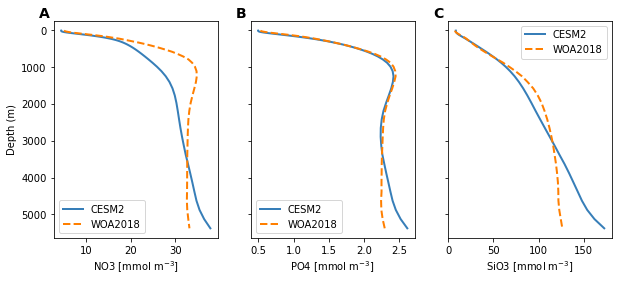

In [9]:
fig = plt.figure(figsize=(10, 4))

units = glb_avg.NO3.units

axs = []
for n, v in enumerate(nutrients):
    ax = fig.add_subplot(1, 3, n+1)
    axs.append(ax)
    
    ax.plot(glb_avg[v], glb_avg.z_t, '-', linewidth=2, color='#377eb8', label='CESM2')
    ax.plot(glb_avg[f'{v}_obs'], glb_avg.z_t, '--', linewidth=2, color='#ff7f00', label='WOA2018')

    ax.set(xlabel=f'{v} [{units}]')
    if n == 0:
        ax.set(ylabel='Depth (m)')
    else:
        ax.set_yticklabels([])
    plt.gca().invert_yaxis()
    ax.legend()
    
utils.label_plots(fig, axs, xoff=-0.02, yoff=0.01) 
utils.savefig('nutrients-global-profiles')

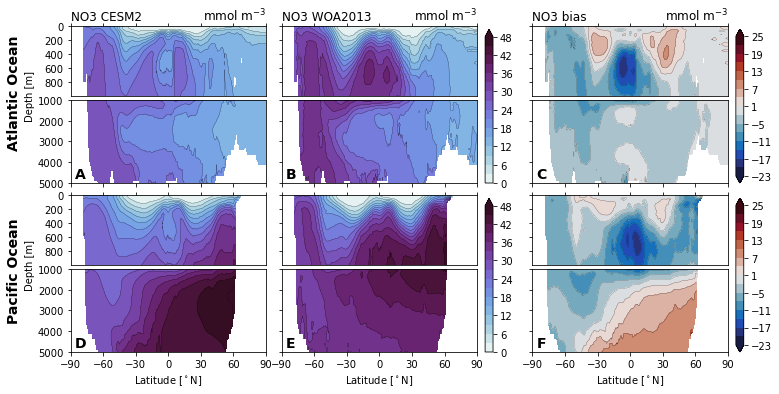

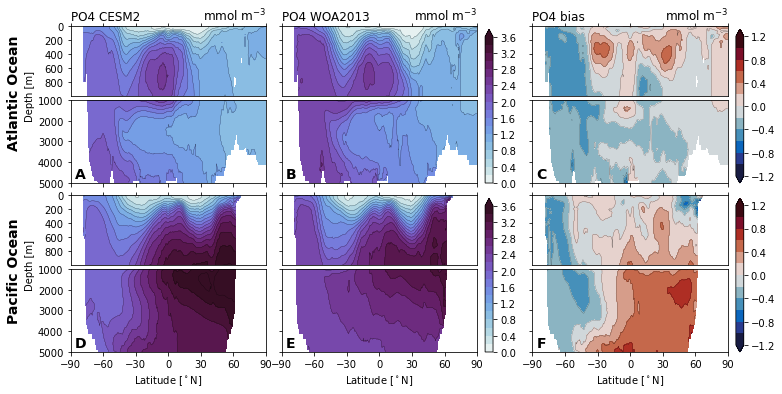

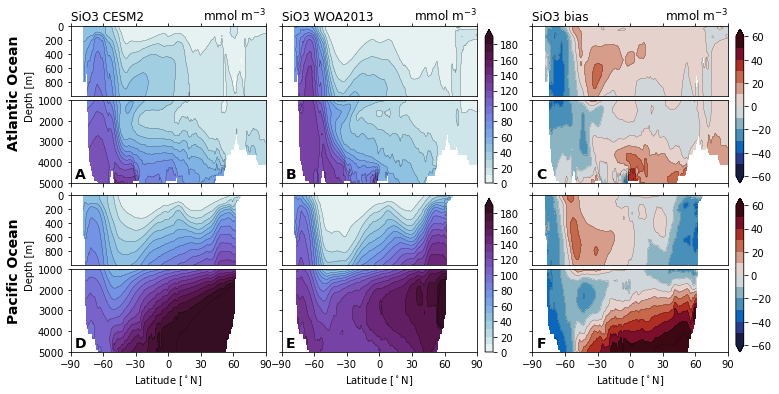

In [10]:
levels = dict(
    NO3=np.arange(0, 51, 3),
    PO4=np.arange(0, 3.8, 0.2),
    SiO3=np.arange(0, 200, 10),
)

    
levels_bias = dict(
    NO3=np.arange(-23, 26, 3),
    PO4=np.arange(-1.2, 1.4, 0.2),
    SiO3=np.arange(-60, 70, 10),
)    

contour_spec = dict(
    NO3=dict(
        levels=levels['NO3'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['NO3'], ncolors=cmap_field.N),
    ),
    NO3_bias=dict(
        levels=levels_bias['NO3'], #np.arange(-12, 14, 2),
        extend='both',        
        cmap=cmap_bias,
        norm=colors.BoundaryNorm(levels_bias['NO3'], ncolors=cmap_bias.N),        
    ),
    PO4=dict(
        levels=levels['PO4'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['PO4'], ncolors=cmap_field.N),        
    ),
    PO4_bias=dict(
        levels=levels_bias['PO4'], #np.arange(-1., 1.15, 0.15),
        extend='both',
        cmap=cmap_bias,   
        norm=colors.BoundaryNorm(levels_bias['PO4'], ncolors=cmap_bias.N),                
    ),
    SiO3=dict(
        levels=levels['SiO3'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['SiO3'], ncolors=256),        
    ),
    SiO3_bias=dict(
        levels=levels_bias['SiO3'], #np.arange(-50, 55, 5),
        extend='both',
        cmap=cmap_bias,   
        norm=colors.BoundaryNorm(levels_bias['SiO3'], ncolors=cmap_bias.N),                
    ),    
    
)
contour_spec.update({f'{v}_obs': contour_spec[v] for v in nutrients})

plot_basins = ['Atlantic Ocean', 'Pacific Ocean']

gss = []

col_name = ['CESM2', 'WOA2013', 'bias']
for nutrient in nutrients:    
    fig = plt.figure(figsize=(11, 6))
    gs = gridspec.GridSpec(2, 3)
    
    axs_surf = []
    axs_deep = []
    cfs_surf = []
    for row, basin in enumerate(plot_basins):
        
        axs_surf_row = []
        axs_deep_row = []
        cfs_surf_row = []
        for col, v in enumerate([nutrient, f'{nutrient}_obs', f'{nutrient}_bias']):
            gsi = gridspec.GridSpecFromSubplotSpec(100, 1, subplot_spec=gs[row, col])

            ax_surf = fig.add_subplot(gsi[:45, 0])
            ax_deep = fig.add_subplot(gsi[47:, 0])
            
            axs_surf_row.append(ax_surf)
            axs_deep_row.append(ax_deep)
            
            cf = ax_surf.contourf(
                ds_zonal_mean.lat_t, ds_zonal_mean.z_t, 
                ds_zonal_mean[v].sel(basins=basin),
                **contour_spec[v]
            )
            cfs_surf_row.append(cf)
            
            ax_deep.contourf(
                ds_zonal_mean.lat_t, ds_zonal_mean.z_t, 
                ds_zonal_mean[v].sel(basins=basin),
                **contour_spec[v]
            )
                             
            ax_surf.contour(
                ds_zonal_mean.lat_t, ds_zonal_mean.z_t, 
                ds_zonal_mean[v].sel(basins=basin),
                levels=contour_spec[v]['levels'], colors='k', linewidths=0.2,
            )

            ax_deep.contour(
                ds_zonal_mean.lat_t, ds_zonal_mean.z_t, 
                ds_zonal_mean[v].sel(basins=basin),
                levels=contour_spec[v]['levels'], colors='k', linewidths=0.2,
            )
            
            
            ax_surf.set_ylim([1000., 0.])
            ax_surf.set_yticks(np.arange(0, 1000, 200))
            ax_surf.set_xticklabels([])
            ax_surf.xaxis.set_ticks_position('top')
            ax_surf.set_xticks(np.arange(-90, 110, 30))
            
            ax_deep.set_ylim([5000., 1000.])
            ax_deep.xaxis.set_ticks_position('bottom')
            ax_deep.set_xticks(np.arange(-90, 110, 30))
            
            if col == 0:
                ax_deep.set_ylabel('Depth [m]')
                ax_deep.yaxis.set_label_coords(-0.18, 1.05)
            else:
                ax_surf.set_yticklabels('')
                ax_deep.set_yticklabels('')
                
            if row == 1:
                ax_deep.set_xlabel('Latitude [$^\circ$N]')
            else:
                ax_surf.set_title(f'{nutrient} {col_name[col]}', loc='left')
                ax_surf.set_title('mmol m$^{-3}$', loc='right')                            
                ax_deep.set_xticklabels('')


        axs_surf.append(axs_surf_row)
        axs_deep.append(axs_deep_row)
        cfs_surf.append(cfs_surf_row)
        
    gs.update(left=0.11, right=0.89, wspace=0.08,hspace=0.075)

    #-- shift the right two columns over to make room for colorbar
    offset = 0.05
    for i in range(2):
        for j in range(2, 3):
            p0 = axs_surf[i][j].get_position()
            axs_surf[i][j].set_position([p0.x0+offset,p0.y0,p0.width,p0.height])

            p0 = axs_deep[i][j].get_position()
            axs_deep[i][j].set_position([p0.x0+offset,p0.y0,p0.width,p0.height])


    #-- add colorbars
    for i in range(2):
        for j in [1, 2]:
            p0 = axs_surf[i][j].get_position()
            p1 = axs_deep[i][j].get_position()

            cbaxes = fig.add_axes([p1.x0 + p1.width + 0.01, 
                                   p1.y0 + 0.0, 
                                   0.01, 
                                   p0.height + p1.height - 0.0])
            cb = fig.colorbar(cfs_surf[i][j], cax=cbaxes)
    
    fig.text(0.03, 0.6, plot_basins[0],
             fontsize=14.,
             fontweight = 'semibold',rotation=90);

    fig.text(0.03, 0.2, plot_basins[1],
             fontsize=14.,
             fontweight = 'semibold',rotation=90);
    
    utils.label_plots(fig, [ax for ax_row in axs_deep for ax in ax_row] , xoff=0.005, yoff=-0.18)
    utils.savefig(f'nutrients-sections-{nutrient}')

## 